<a href="https://colab.research.google.com/github/Asalbek/ML-projects/blob/main/Pulmonary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from fastai.vision.all import *

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("samuel156/lungxrays-grayscale")

print("Path to dataset files:", path)

100%|██████████| 1.89G/1.89G [00:23<00:00, 87.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/samuel156/lungxrays-grayscale/versions/1


['Corona Virus Disease', 'Normal', 'Pneumonia', 'Tuberculosis']


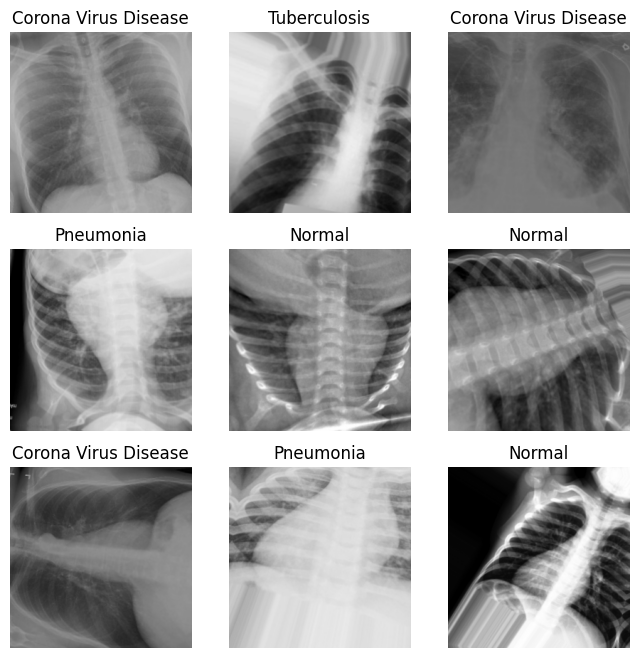

In [4]:
# Load and preprocess the images
data = ImageDataLoaders.from_folder(
    path,
    valid_pct=0.2,                   # Use 20% of data for validation
    item_tfms=Resize(256),           # Resize images to 256x256 (original size will be center-cropped)
    batch_tfms=aug_transforms(       # Apply data augmentation
        do_flip=True, flip_vert=True,
        max_rotate=15, max_zoom=1.1,
        max_lighting=0.2, max_warp=0.2,
        p_affine=0.75, p_lighting=0.75
    )
)

# Verify data classes and a sample batch
print(data.vocab)  # Output should be: ['COVID-19', 'pneumonia', 'tuberculosis', 'normal']
data.show_batch(max_n=9, figsize=(8, 8))


In [5]:
# Initialize the model with ResNet50
learn = cnn_learner(data, resnet50, metrics=[accuracy, error_rate])

# Show the model architecture
learn.model


/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 164MB/s]


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [6]:
# Step 1: Train the head layers only
learn.fine_tune(3, freeze_epochs=2)  # 3 epochs, with the first 2 epochs freezing the body

# Step 2: Unfreeze and fine-tune entire model for better accuracy
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-5, 1e-3))  # Train with lower learning rates to avoid overfitting


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.566376,0.454043,0.855028,0.144972,03:15
1,0.365243,0.277676,0.908698,0.091302,03:10


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.229887,0.216107,0.925355,0.074645,03:17
1,0.185807,0.166857,0.942011,0.057989,03:10
2,0.140158,0.173123,0.938310,0.061690,03:14


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.134991,0.157910,0.942628,0.057372,03:14
1,0.134457,0.180849,0.941394,0.058606,03:14
2,0.113423,0.121223,0.958051,0.041949,03:17
3,0.095814,0.124282,0.953115,0.046885,03:13
4,0.088324,0.128766,0.953115,0.046885,03:15


                      precision    recall  f1-score   support

Corona Virus Disease       0.94      0.99      0.97       394
              Normal       0.98      0.90      0.94       429
           Pneumonia       0.90      0.98      0.94       405
        Tuberculosis       1.00      0.94      0.97       393

            accuracy                           0.95      1621
           macro avg       0.96      0.95      0.95      1621
        weighted avg       0.96      0.95      0.95      1621



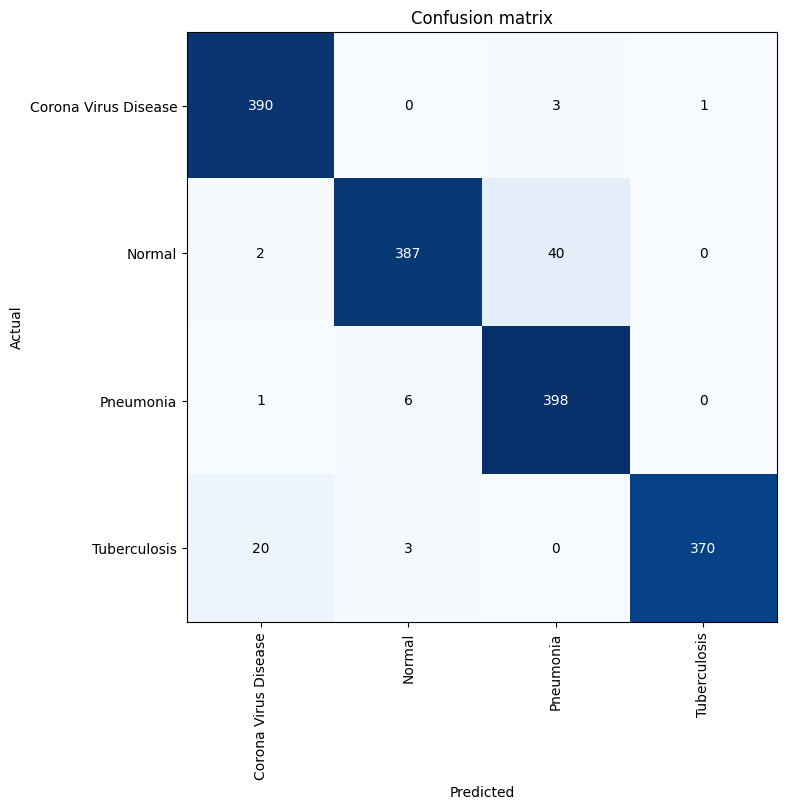

In [8]:
# Confusion matrix and accuracy metrics
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8, 8), dpi=100)

# Classification report with precision, recall, and F1-score
from sklearn.metrics import classification_report

preds, targs = learn.get_preds()
print(classification_report(targs, preds.argmax(dim=1), target_names=data.vocab))


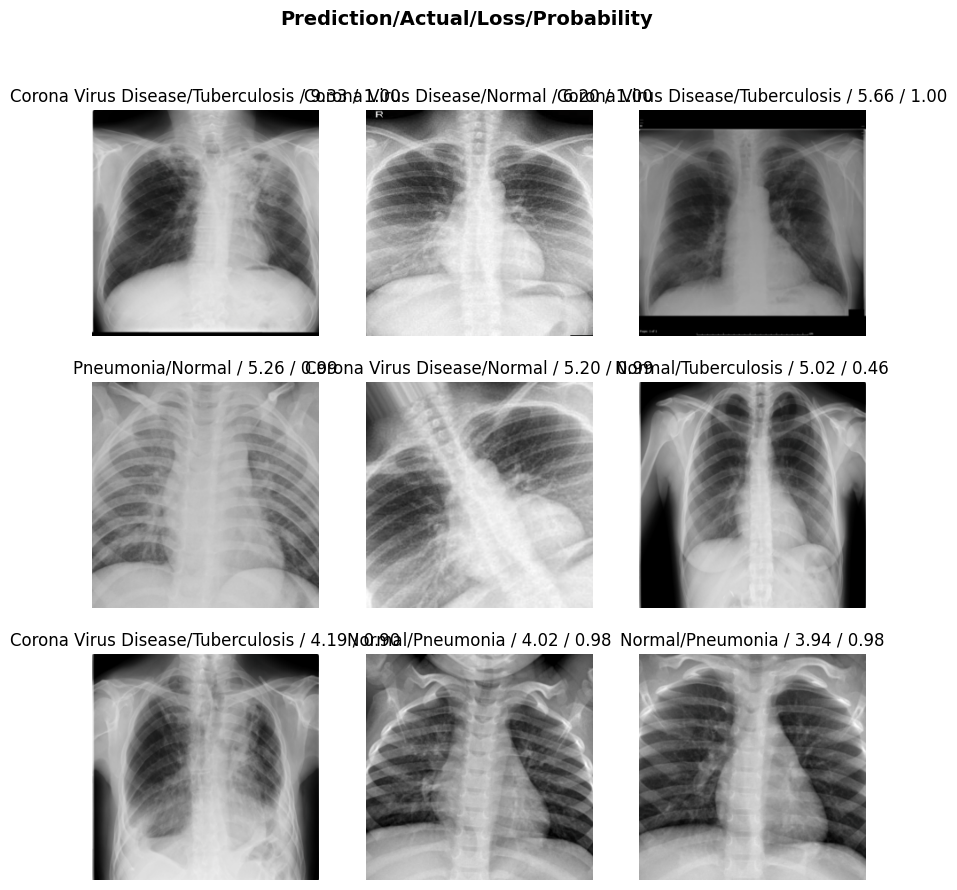

In [10]:
# Plot top losses to see model focus areas, removing the 'heatmap' argument
interp.plot_top_losses(9, figsize=(10, 10))

In [18]:
import os

# Print the current working directory
print("Current working directory:", os.getcwd())

# Export the trained model to the current directory
learn.export("/content/lung_disease_classifier.pkl")


Current working directory: /content


In [19]:
from fastai.vision.all import load_learner, PILImage
from google.colab import files
from IPython.display import display
import matplotlib.pyplot as plt
import torch

# Load the saved model
learn_inf = load_learner("lung_disease_classifier.pkl")


Please upload an X-ray image:


Saving 0._big_gallery.jpeg to 0._big_gallery.jpeg


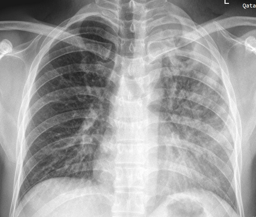


**Prediction:** Pneumonia
**Confidence:** 66.85%

**Class Probabilities:**
Corona Virus Disease: 18.48%
Normal: 14.67%
Pneumonia: 66.85%
Tuberculosis: 0.00%


In [30]:
# Upload the X-ray image
print("Please upload an X-ray image:")
uploaded_file = files.upload()

# Load and preprocess the image
for filename in uploaded_file.keys():
    img = PILImage.create(filename)
    display(img.to_thumb(256, 256))  # Display the uploaded image thumbnail

    # Make a prediction
    pred, pred_idx, probs = learn_inf.predict(img)

    # Display the prediction and probability
    print(f"\n**Prediction:** {pred}")
    print(f"**Confidence:** {probs[pred_idx].item() * 100:.2f}%")
    print("\n**Class Probabilities:**")
    for idx, label in enumerate(learn_inf.dls.vocab):
        print(f"{label}: {probs[idx].item() * 100:.2f}%")
